In [1]:
import pandas as pd
import os
import h5py
import numpy as np

In [2]:
visium_output_dir = "/storage/research/dbmr_luisierlab/temp/lfournier/Data/Ovarian_Visium_GTOP/hg38/spaceranger/D1_NAB_HUG_03/outs"
barcode_mappings = pd.read_parquet(os.path.join(visium_output_dir, "barcode_mappings.parquet"))

In [3]:
print("Barcode mappings preview:")
print(f"Barcode mappings shape: {barcode_mappings.shape}")
barcode_mappings.head()


Barcode mappings preview:
Barcode mappings shape: (11222500, 6)


,square_002um,square_008um,square_016um,cell_id,in_nucleus,in_cell
0,s_002um_00000_00000-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,False,True
1,s_002um_00000_00001-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,True,True
2,s_002um_00000_00002-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,True,True
3,s_002um_00000_00003-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,False,True
4,s_002um_00000_00004-1,s_008um_00000_00001-1,s_016um_00000_00000-1,cellid_000379646-1,False,True


## Understanding molecule_info.h5

The `molecule_info.h5` file contains **molecule-level** information for each detected UMI (Unique Molecular Identifier). This is more detailed than the gene expression count matrix.

### What is a "molecule"?

**Important distinction:**
- **Molecule** = One original mRNA molecule (represented by a unique UMI)
- **Read** = One sequencing read (there can be multiple reads per molecule)

During library prep, each mRNA molecule gets tagged with a unique barcode (UMI). When sequenced:
- The same molecule may be sequenced **multiple times** → multiple reads
- But they all have the **same UMI** → counted as **one molecule**

This is why UMIs are crucial: they let us count actual molecules, not just reads, which removes PCR amplification bias.

### Key datasets:
- **barcode_idx**: Index into the barcode list (which barcode/spot detected this molecule)
- **count**: Number of **reads** supporting this UMI/molecule (how many times we sequenced it)
- **feature_idx**: Index into the gene/feature list (which gene this molecule represents)
- **gem_group**: GEM (Gel Bead-in-EMulsion) group identifier
- **umi**: The actual UMI sequence identifying this unique molecule
- **umi_type**: Classification of the UMI (e.g., valid, corrected, etc.)

Each row across these arrays represents **one unique molecule** (UMI) detected in the experiment.

### Summary

**molecule_info.h5 vs count matrix:**
- **molecule_info.h5**: Raw molecule-level data - one entry per UMI detected
  - Useful for: QC, calculating molecule statistics, understanding read depth per UMI
  - Size: Can be very large (millions of molecules)
  
- **Count matrix** (e.g., filtered_feature_bc_matrix.h5): Aggregated gene × barcode matrix
  - Useful for: Standard analysis (clustering, DE, visualization)
  - Size: Smaller, easier to work with (genes × spots)

**Key insight**: The count matrix is derived by aggregating the molecule_info.h5 data - counting how many unique UMIs (molecules) were detected for each gene in each barcode/spot.

In [4]:
visium_file = os.path.join(visium_output_dir, "molecule_info.h5")

In [5]:
# Let's explore the molecule-level data
with h5py.File(visium_file, "r") as f:
    # Load key datasets
    barcode_idx = f['barcode_idx'][:]
    count = f['count'][:]
    feature_idx = f['feature_idx'][:]
    
    # Load metadata
    barcodes = [b.decode() if isinstance(b, bytes) else b for b in f['barcodes'][:]]
    features = [feat.decode() if isinstance(feat, bytes) else feat for feat in f['features/id'][:]]
    
    print(f"Total number of molecules detected: {len(barcode_idx):,}")
    print(f"Total number of barcodes (spots): {len(barcodes):,}")
    print(f"Total number of features (genes): {len(features):,}")
    print(f"\nMolecule counts distribution:")
    print(f"  Min reads per molecule: {count.min()}")
    print(f"  Max reads per molecule: {count.max()}")
    print(f"  Mean reads per molecule: {count.mean():.2f}")
    print(f"  Median reads per molecule: {np.median(count):.0f}")

Total number of molecules detected: 17,437,033
Total number of barcodes (spots): 11,222,500
Total number of features (genes): 38,606

Molecule counts distribution:
  Min reads per molecule: 1
  Max reads per molecule: 573
  Mean reads per molecule: 24.98
  Median reads per molecule: 6


In [6]:
# Check if barcodes include different bin sizes (002um, 008um, 016um)
print("Checking barcode structure...")
print(f"\nFirst 10 barcodes:")
for i in range(min(10, len(barcodes))):
    print(f"  {barcodes[i]}")

# Check barcode_mappings to understand the structure
print(f"\nBarcode mappings columns: {barcode_mappings.columns.tolist()}")
print(f"\nBarcode mappings shape: {barcode_mappings.shape}")
barcode_mappings.head(10)

Checking barcode structure...

First 10 barcodes:
  s_002um_00000_00000
  s_002um_00000_00001
  s_002um_00000_00002
  s_002um_00000_00003
  s_002um_00000_00004
  s_002um_00000_00005
  s_002um_00000_00006
  s_002um_00000_00007
  s_002um_00000_00008
  s_002um_00000_00009

Barcode mappings columns: ['square_002um', 'square_008um', 'square_016um', 'cell_id', 'in_nucleus', 'in_cell']

Barcode mappings shape: (11222500, 6)


,square_002um,square_008um,square_016um,cell_id,in_nucleus,in_cell
0,s_002um_00000_00000-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,False,True
1,s_002um_00000_00001-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,True,True
2,s_002um_00000_00002-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,True,True
3,s_002um_00000_00003-1,s_008um_00000_00000-1,s_016um_00000_00000-1,cellid_000381518-1,False,True
4,s_002um_00000_00004-1,s_008um_00000_00001-1,s_016um_00000_00000-1,cellid_000379646-1,False,True
5,s_002um_00000_00005-1,s_008um_00000_00001-1,s_016um_00000_00000-1,cellid_000379646-1,True,True
6,s_002um_00000_00006-1,s_008um_00000_00001-1,s_016um_00000_00000-1,cellid_000379646-1,True,True
7,s_002um_00000_00007-1,s_008um_00000_00001-1,s_016um_00000_00000-1,cellid_000379646-1,True,True
8,s_002um_00000_00008-1,s_008um_00000_00002-1,s_016um_00000_00001-1,cellid_000379646-1,False,True
9,s_002um_00000_00009-1,s_008um_00000_00002-1,s_016um_00000_00001-1,cellid_000380758-1,True,True


### Visium HD Bin Sizes

In Visium HD, Space Ranger generates multiple resolutions:
- **002um bins**: 2µm × 2µm squares (finest resolution, ~0.5 cells)
- **008um bins**: 8µm × 8µm squares (medium resolution, ~1-2 cells)
- **016um bins**: 16µm × 16µm squares (coarser resolution, ~5-10 cells)

The **barcode_mappings.parquet** file maps between these different resolutions. The molecule_info.h5 file likely contains barcodes at the **finest resolution (002um)**, and you can aggregate them to coarser resolutions using the mappings.

**Important**: When you see 11+ million barcodes, these are mostly at the 002um resolution, covering the entire capture area at the finest granularity. Most of these will be empty or have very few molecules - only the barcodes under tissue are typically used for analysis.

In [7]:
# Count how many barcodes actually have molecules
with h5py.File(visium_file, "r") as f:
    barcode_idx = f['barcode_idx'][:]
    unique_barcodes_with_data = np.unique(barcode_idx)
    
    print(f"Total barcodes in reference list: {len(barcodes):,}")
    print(f"Barcodes with at least 1 molecule: {len(unique_barcodes_with_data):,}")
    print(f"Empty barcodes: {len(barcodes) - len(unique_barcodes_with_data):,}")
    print(f"\nPercentage of barcodes with data: {100 * len(unique_barcodes_with_data) / len(barcodes):.2f}%")

Total barcodes in reference list: 11,222,500
Barcodes with at least 1 molecule: 5,454,877
Empty barcodes: 5,767,623

Percentage of barcodes with data: 48.61%


In [8]:
# Check what resolution-specific matrices are available
import glob

# Look for binned count matrices
binned_dirs = glob.glob(os.path.join(visium_output_dir, "binned_outputs", "*"))
print("Available binned outputs:")
for d in binned_dirs:
    print(f"  {os.path.basename(d)}")
    
# Check if there are h5 files for different resolutions
if binned_dirs:
    example_dir = binned_dirs[0]
    files = os.listdir(example_dir)
    print(f"\nFiles in {os.path.basename(example_dir)}:")
    for f in files:
        print(f"  {f}")

Available binned outputs:
  square_008um
  square_016um
  square_002um

Files in square_008um:
  raw_feature_bc_matrix
  analysis
  filtered_feature_bc_matrix.h5
  cloupe.cloupe
  filtered_feature_bc_matrix
  raw_feature_bc_matrix.h5
  spatial


In [9]:
# Load the 016um resolution matrix to get median UMI counts per spot
import scanpy as sc

# Try to find and load the 016um matrix
square_016um_dir = os.path.join(visium_output_dir, "binned_outputs", "square_016um")

if os.path.exists(square_016um_dir):
    # Load with scanpy
    adata_016um = sc.read_10x_h5(os.path.join(square_016um_dir, "filtered_feature_bc_matrix.h5"))
    
    print(f"Loaded 016um matrix:")
    print(f"  Shape: {adata_016um.shape} (spots × genes)")
    print(f"  Total UMIs: {adata_016um.X.sum():,.0f}")
    
## Load hg38 annotation to keep only protein-coding genes

from genomemanager.gtf_utils import read_gtf

hg38 = read_gtf("/storage/research/dbmr_luisierlab/group/genomics/annotation/hg38/GENCODE/gencode.v44.chr_patch_hapl_scaff.annotation.gtf") 

hg38_coding = hg38[hg38["gene_type"] == "protein_coding"]
hg38_coding_genes = list(hg38_coding['gene_name'].unique())
adata_coding_genes = [gene for gene in adata_016um.var_names if gene in hg38_coding_genes]

# Fix duplicate gene names in adata_016um
print(f"Checking for duplicates...")
print(f"Total genes: {len(adata_016um.var_names)}")
print(f"Unique genes: {len(adata_016um.var_names.unique())}")

if len(adata_016um.var_names) != len(adata_016um.var_names.unique()):
    print("\nMaking gene names unique...")
    adata_016um.var_names_make_unique()
    print("Done!")

# Check if there are duplicate gene names and fix them
print(f"Total genes in adata_016um: {len(adata_016um.var_names)}")
print(f"Unique genes in adata_016um: {len(adata_016um.var_names.unique())}")

if len(adata_016um.var_names) != len(adata_016um.var_names.unique()):
    print("\nDuplicate gene names detected! Making them unique...")
    adata_016um.var_names_make_unique()
    print(f"After making unique: {len(adata_016um.var_names)} unique gene names")

# Filter adata_016um to retain only genes present in adata_coding_genes
genes_to_keep = [g for g in adata_coding_genes if g in adata_016um.var_names]
print(f"\nFound {len(genes_to_keep)} coding genes in adata_016um (of {len(adata_coding_genes)})")

if len(genes_to_keep) == 0:
    raise RuntimeError("No coding genes from adata_coding_genes were found in adata_016um.var_names")

# Subset without modifying the original adata_016um
adata_016um_coding = adata_016um[:, genes_to_keep].copy()



/storage/homefs/lf25x455/.conda/envs/scRNApy-new/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loaded 016um matrix:
  Shape: (132160, 38606) (spots × genes)
  Total UMIs: 17,190,760
Checking for duplicates...
Total genes: 38606
Unique genes: 38584

Making gene names unique...
Done!
Total genes in adata_016um: 38606
Unique genes in adata_016um: 38606

Found 19418 coding genes in adata_016um (of 19418)


/storage/homefs/lf25x455/.conda/envs/scRNApy-new/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
print(f"adata_016um_coding shape: {adata_016um_coding.shape} (spots × genes)")

## Number of molecules per spot after filtering to protein-coding genes
umis_per_spot_016um_coding = np.array(adata_016um_coding.X.sum(axis=1)).flatten()

## Calculate median
print(f"\nUMIs per 16um spot (protein-coding genes only) statistics:")
print(f"  Min: {umis_per_spot_016um_coding.min():.0f}")
print(f"  Max: {umis_per_spot_016um_coding.max():.0f}")
print(f"  Mean: {umis_per_spot_016um_coding.mean():.2f}")
print(f"  Median: {np.median(umis_per_spot_016um_coding):.0f}")

adata_016um_coding shape: (132160, 19418) (spots × genes)

UMIs per 16um spot (protein-coding genes only) statistics:
  Min: 0
  Max: 823
  Mean: 126.74
  Median: 87


In [11]:
import anndata as ad
HER2_emb = ad.read_h5ad("/storage/research/dbmr_luisierlab/temp/lfournier/repositories/TumorArchetype-FM/results/HER2/molecular/gene_embedding_HER2.h5ad")

print(f"HER2_emb shape: {HER2_emb.shape} (spots × genes)")

## Number of molecules per spot after filtering to protein-coding genes
umis_per_spot_HER2 = np.array(HER2_emb.X.sum(axis=1)).flatten()

## Calculate median
print(f"\nUMIs per 100um spot (protein-coding genes only) statistics:")
print(f"  Min: {umis_per_spot_HER2.min():.0f}")
print(f"  Max: {umis_per_spot_HER2.max():.0f}")
print(f"  Mean: {umis_per_spot_HER2.mean():.2f}")
print(f"  Median: {np.median(umis_per_spot_HER2):.0f}")

print(f"\nExpected UMIs per 16um spot (protein-coding genes only) statistics:")
print(f"  Min: {umis_per_spot_HER2.min()/((100/16)**2):.0f}")
print(f"  Max: {umis_per_spot_HER2.max()/((100/16)**2):.0f}")
print(f"  Mean: {umis_per_spot_HER2.mean()/((100/16)**2):.2f}")
print(f"  Median: {np.median(umis_per_spot_HER2)/((100/16)**2):.0f}")

HER2_emb shape: (13620, 18758) (spots × genes)

UMIs per 100um spot (protein-coding genes only) statistics:
  Min: 0
  Max: 47186
  Mean: 4631.69
  Median: 3282

Expected UMIs per 16um spot (protein-coding genes only) statistics:
  Min: 0
  Max: 1208
  Mean: 118.57
  Median: 84


## UMIs per spots

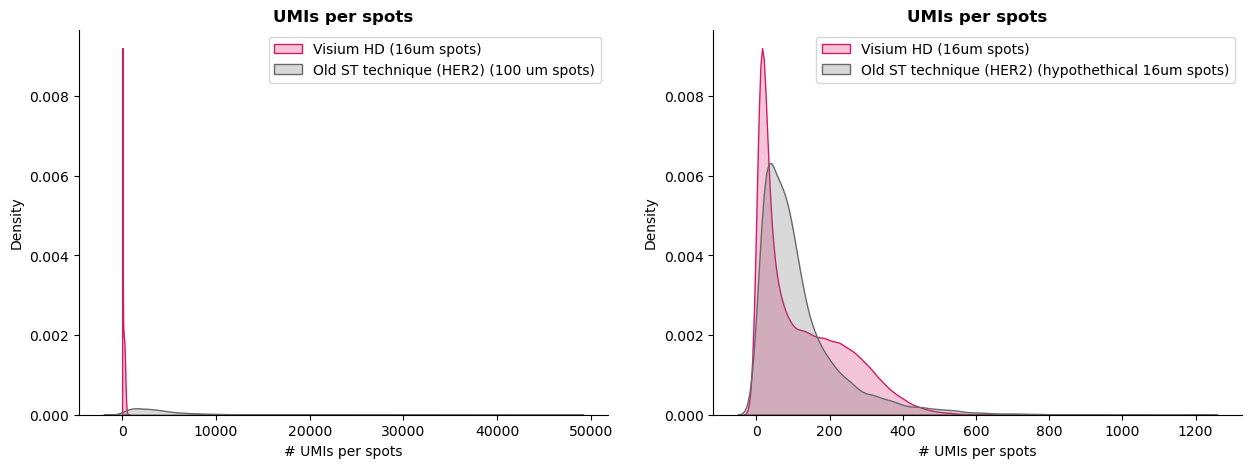

In [12]:
# Plot the distributions of UMIs per spots
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(umis_per_spot_016um_coding, fill=True, label="Visium HD (16um spots)", color="#d51968")
sns.kdeplot(umis_per_spot_HER2, fill=True, label="Old ST technique (HER2) (100 um spots)", color="dimgray")
plt.title("UMIs per spots", weight='bold')
plt.legend()
plt.xlabel("# UMIs per spots")
sns.despine()

plt.subplot(1, 2, 2)
sns.kdeplot(umis_per_spot_016um_coding, fill=True, label="Visium HD (16um spots)", color="#d51968")
sns.kdeplot(umis_per_spot_HER2/((100/16)**2), fill=True, label="Old ST technique (HER2) (hypothethical 16um spots)", color="dimgray")
plt.title("UMIs per spots", weight='bold')
plt.legend()
plt.xlabel("# UMIs per spots")
sns.despine()

## Pseudobulk

In [13]:
# Calculate pseudobulk: sum all UMIs across all spots per gene
pseudobulk = np.array(adata_016um_coding.X.sum(axis=0)).flatten()

print(f"Pseudobulk shape: {pseudobulk.shape}")
print(f"Total UMIs: {pseudobulk.sum():,.0f}")

df_pseudobulk = pd.DataFrame(pseudobulk, index=adata_016um_coding.var_names, columns=["counts"])
df_pseudobulk.to_csv("pseudobulk_spaceranger_016um_protein_coding.tsv", sep="\t")

df_pseudobulk_log = np.log2(df_pseudobulk + 1)

Pseudobulk shape: (19418,)
Total UMIs: 16,750,203


In [14]:
adata_016um_coding

AnnData object with n_obs × n_vars = 132160 × 19418
    var: 'gene_ids', 'feature_types', 'genome'

In [15]:
surface_covered = (16*16) * len(adata_016um_coding.obs)  # in um^2
print(f"Total surface covered by 16um spots: {surface_covered/10e6:.2f} mm^2")

surface_covered_HER2 = (100*100) * len(HER2_emb.obs)  # in um^2
print(f"Total surface covered by 100um spots: {surface_covered_HER2/10e6:.2f} mm^2")

Total surface covered by 16um spots: 3.38 mm^2
Total surface covered by 100um spots: 13.62 mm^2


In [16]:
surface_ratio = surface_covered_HER2 / surface_covered

In [17]:
pseudobulk_HER2 = np.array(HER2_emb.X.sum(axis=0)).flatten()

df_pseudobulk_HER2 = pd.DataFrame(pseudobulk_HER2, index=HER2_emb.var_names, columns=["counts"])
df_pseudobulk_HER2_log = np.log2(df_pseudobulk_HER2+1)

df_pseudobulk_hypothetical_HER2 = pd.DataFrame(pseudobulk_HER2/surface_ratio, index=HER2_emb.var_names, columns=["counts"])
df_pseudobulk_hypothetical_HER2_log = np.log2(df_pseudobulk_hypothetical_HER2 + 1)

print(f"Pseudobulk shape: {pseudobulk_HER2.shape}")
print(f"Total UMIs: {pseudobulk_HER2.sum():,.0f}")

Pseudobulk shape: (18758,)
Total UMIs: 63,083,592


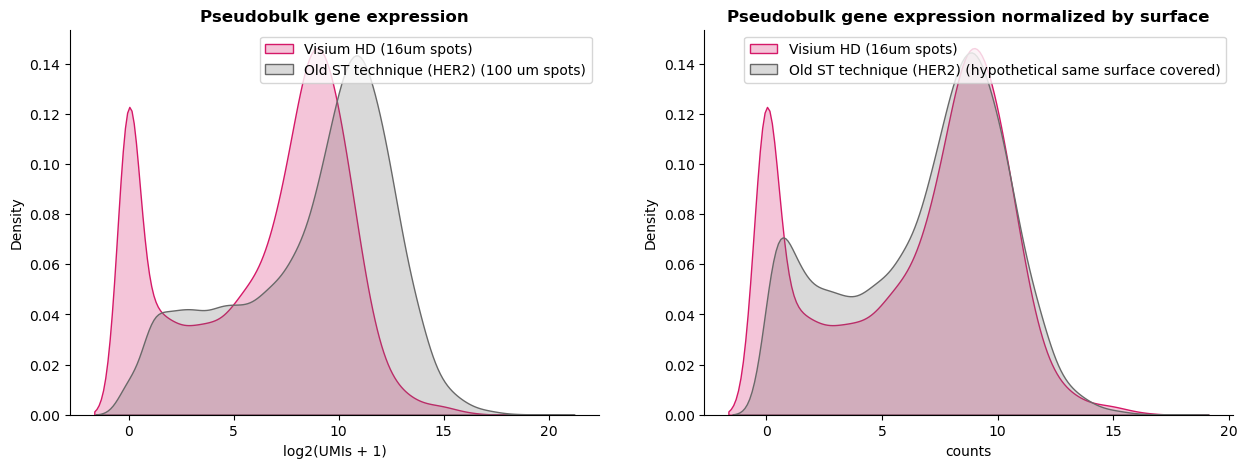

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(df_pseudobulk_log["counts"], fill=True, label="Visium HD (16um spots)", color="#d51968"
            )
sns.kdeplot(df_pseudobulk_HER2_log["counts"], fill=True, label="Old ST technique (HER2) (100 um spots)", color="dimgray"
            )
plt.title("Pseudobulk gene expression", weight='bold')
plt.legend()

plt.xlabel("log2(UMIs + 1)")
sns.despine()

plt.subplot(1, 2, 2)
sns.kdeplot(df_pseudobulk_log["counts"], fill=True, label="Visium HD (16um spots)", color="#d51968"
            )
sns.kdeplot(df_pseudobulk_hypothetical_HER2_log["counts"], fill=True, label="Old ST technique (HER2) (hypothetical same surface covered)", color="dimgray"
            )
plt.title("Pseudobulk gene expression normalized by surface", weight='bold')
plt.legend()
sns.despine()


Threshold based on the 95.0th quantile: 4.721
Intersection x point: 4.5475053787231445


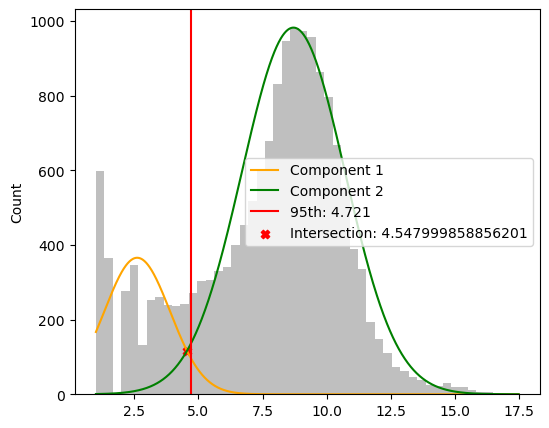

In [47]:
from bulkanalysis.filtering import gmm_threshold

t = gmm_threshold(df_pseudobulk_log[df_pseudobulk_log["counts"] > 0], quantile_threshold=0.95, return_int=False)

In [48]:
df_pseudobulk_log[df_pseudobulk_log["counts"] > t]

,counts
NOC2L,9.243174
KLHL17,7.044394
HES4,6.942514
ISG15,11.738515
AGRN,10.266787
...,...
MT-CYB,14.724833
MAFIP,5.807355
ENSG00000278384,5.247928
ENSG00000273748,5.392317


## Spaceranger vs STAR+featureCounts

In [19]:
# Compare with STAR + featureCounts results

file_path = "/storage/research/dbmr_luisierlab/temp/lfournier/Data/Ovarian_Visium_GTOP/hg38/featureCounts/all_samples_hg38.txt"

# Read featureCounts output
# Skip the first comment line, use the second line as header
df_counts = pd.read_csv(file_path, sep='\t', skiprows=1, index_col=0)

# Keep only the count columns (last 2 columns - the BAM files)
count_columns = df_counts.columns[-2:]
df_counts = df_counts[count_columns]

# Rename columns to sample names
df_counts.columns = ["A1", "D1"]

print(f"featureCounts matrix shape: {df_counts.shape}")
print(f"Total reads - A1: {df_counts['A1'].sum():,.0f}")
print(f"Total reads - D1: {df_counts['D1'].sum():,.0f}")

df_counts_log = np.log2(df_counts + 1)

featureCounts matrix shape: (70116, 2)
Total reads - A1: 401,033,310
Total reads - D1: 279,975,606


In [20]:
hg38_coding_ids = list(hg38_coding['gene_id'].unique())

In [21]:
df_counts_log = df_counts_log.loc[[gene for gene in df_counts_log.index if gene in hg38_coding_ids]]

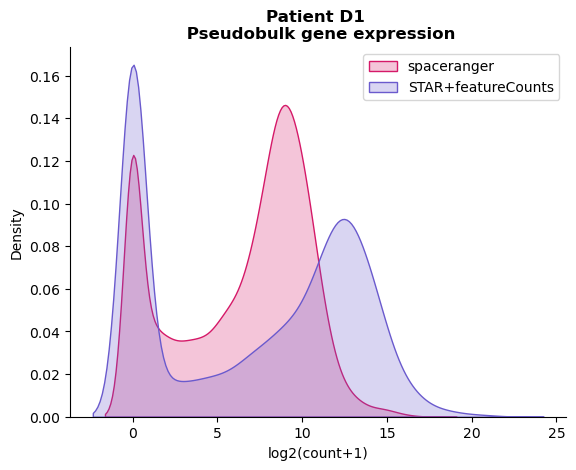

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_pseudobulk_log["counts"], fill=True, label="spaceranger", color='#d51968')
sns.kdeplot(df_counts_log["D1"], fill=True, label="STAR+featureCounts", color="slateblue")
sns.despine()
plt.title("Patient D1 \n Pseudobulk gene expression", weight='bold')
plt.xlabel("log2(count+1)")
plt.legend()

In [23]:
# Example with CD4

gene_of_interest = "CD4"
gene_id_ENS = hg38[hg38['gene_name'] == gene_of_interest]['gene_id'].values[0]

df_pseudobulk.loc["CD4"]

counts    257.0
Name: CD4, dtype: float32

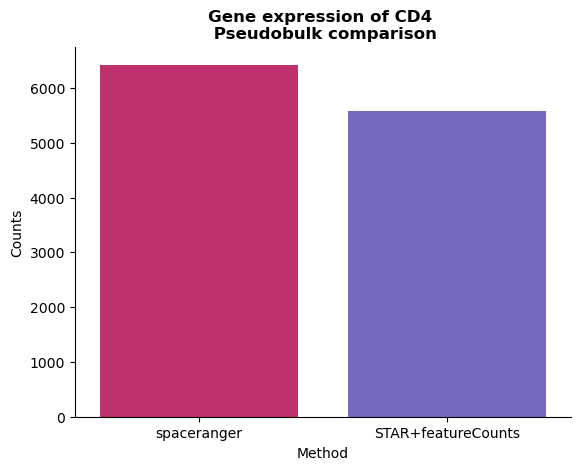

In [24]:
df_counts.loc[gene_id_ENS, "D1"]

sns.barplot(x=["spaceranger", "STAR+featureCounts"], y=[df_pseudobulk.loc["CD4", "counts"]*25, df_counts.loc[gene_id_ENS, "D1"]], palette=["#d51968", "slateblue"])
plt.title(f"Gene expression of {gene_of_interest} \n Pseudobulk comparison", weight='bold')
plt.ylabel("Counts")
plt.xlabel("Method")
sns.despine()


In [25]:
CD4 = adata_016um_coding[:,"CD4"].to_df()

In [26]:
df_pseudobulk_log.loc["CD4", "counts"]

8.011228

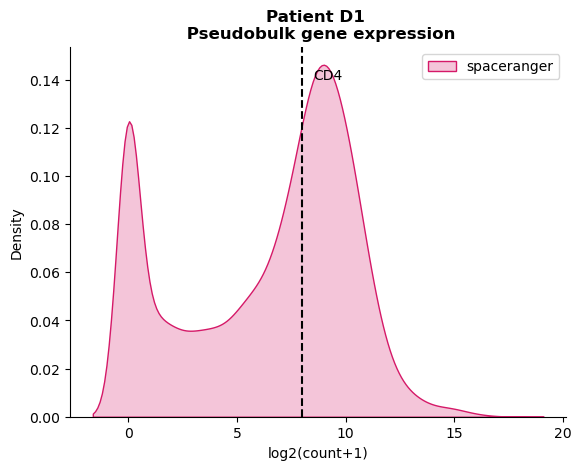

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_pseudobulk_log["counts"], fill=True, label="spaceranger", color='#d51968')
plt.axvline(x=df_pseudobulk_log.loc["CD4", "counts"], linestyle='--', color='black')
plt.text(s="CD4", x=df_pseudobulk_log.loc["CD4", "counts"]+0.5, y=0.14)
sns.despine()
plt.title("Patient D1 \n Pseudobulk gene expression", weight='bold')
plt.xlabel("log2(count+1)")
plt.legend()

In [28]:
len(CD4[CD4["CD4"] > 0])

240

In [29]:
adata_016um_coding[:,"MT-CO1"].to_df().sum()

MT-CO1    49752.0
dtype: float32

In [30]:
adata_016um_coding[:,"GAPDH"].to_df().sum()

GAPDH    45223.0
dtype: float32

In [31]:
adata_016um_coding[:,"ENO1"].to_df().sum()

ENO1    13037.0
dtype: float32

In [32]:
adata_016um_coding[:,"PGK1"].to_df().sum()

PGK1    15150.0
dtype: float32

In [33]:
adata_016um_coding[:,"CD40"].to_df().sum()

CD40    750.0
dtype: float32

In [34]:
adata_016um_coding[:,"HNRNPK"].to_df().sum()

HNRNPK    10275.0
dtype: float32

In [35]:
adata_016um_coding[:,"SPP1"].to_df().sum()

SPP1    19775.0
dtype: float32

In [36]:
adata_016um_coding[:,"CD4"].to_df().sum()

CD4    257.0
dtype: float32

In [37]:
CD4 = adata_016um_coding[:,"CD4"].to_df()
CD4 = CD4[CD4["CD4"] > 0]
CD4

,CD4
s_016um_00157_00219-1,1.0
s_016um_00118_00076-1,1.0
s_016um_00344_00074-1,1.0
s_016um_00284_00092-1,1.0
s_016um_00193_00062-1,1.0
...,...
s_016um_00178_00061-1,3.0
s_016um_00117_00240-1,1.0
s_016um_00265_00000-1,1.0
s_016um_00273_00100-1,1.0


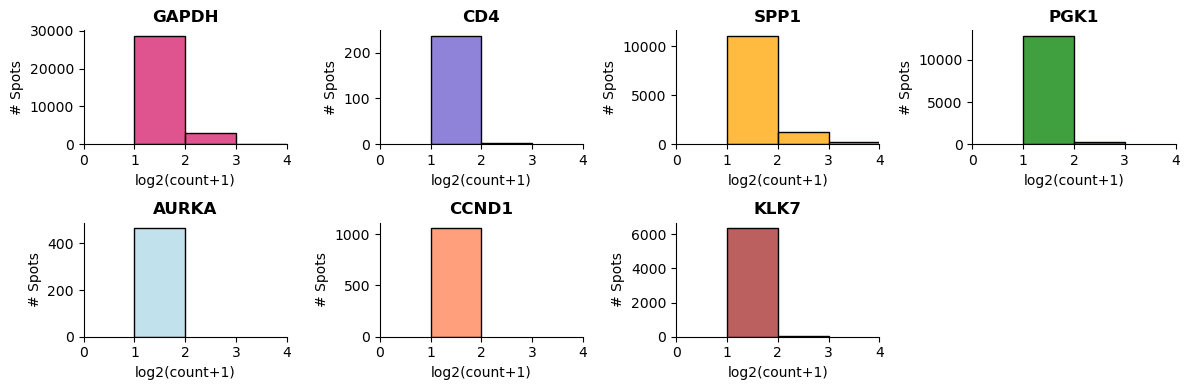

In [38]:
# Plot histograms for multiple genes
genes = ["GAPDH", "CD4", "SPP1", "PGK1", "AURKA", "CCND1", "KLK7"]
colors = ["#d51968", "slateblue", "orange", "green", "lightblue", "coral", "brown", "gray"]

plt.figure(figsize=(12, 4))

for i, gene in enumerate(genes):
    plt.subplot(2, 4, i+1)
    gene_counts = adata_016um_coding[:, gene].to_df()[gene]
    gene_counts_log = np.log2(gene_counts + 1)
    gene_counts_log = gene_counts_log[gene_counts_log > 0]
    
    sns.histplot(gene_counts_log, binwidth=1, color=colors[i], kde=False)
    plt.title(gene, weight='bold')
    plt.xlabel("log2(count+1)")
    plt.ylabel("# Spots")
    sns.despine()
    plt.xlim(0, 4)

plt.tight_layout()

In [39]:
import scanpy as sc

sc.pp.filter_genes(adata_016um_coding, min_cells=0)

/storage/homefs/lf25x455/.conda/envs/scRNApy-new/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Text(0.5, 1.0, 'Number of spots expressing the genes')

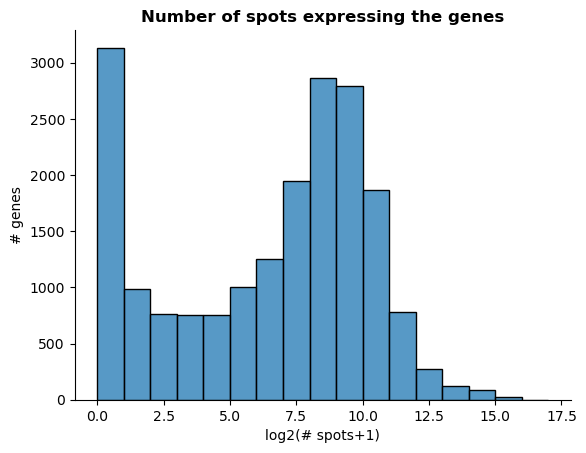

In [40]:
n_spots_per_gene = adata_016um_coding.var['n_cells']
sns.histplot(np.log2(n_spots_per_gene + 1), binwidth=1)
sns.despine()
plt.xlabel("log2(# spots+1)")
plt.ylabel('# genes')
plt.title("Number of spots expressing the genes", weight='bold')


In [41]:
# Number of genes per spot
sc.pp.filter_cells(adata_016um_coding, min_genes=0)

/storage/homefs/lf25x455/.conda/envs/scRNApy-new/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Text(0.5, 1.0, 'Number of genes expressed per spot')

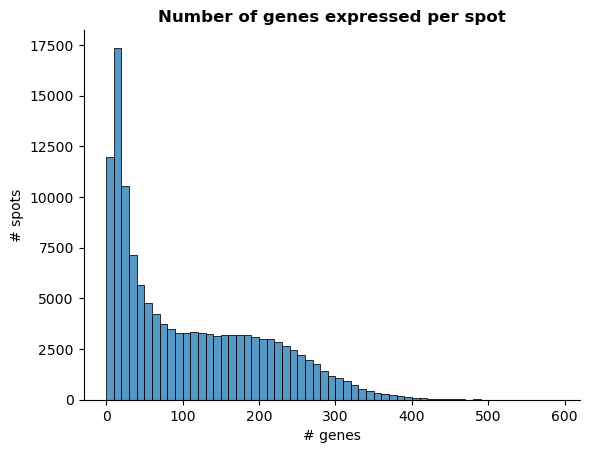

In [42]:
n_genes_per_spot = adata_016um_coding.obs["n_genes"]
sns.histplot(n_genes_per_spot, binwidth=10)
sns.despine()
plt.xlabel("# genes")
plt.ylabel('# spots')
plt.title("Number of genes expressed per spot", weight='bold')

In [43]:
positions = pd.read_parquet("/storage/research/dbmr_luisierlab/temp/lfournier/Data/Ovarian_Visium_GTOP/hg38/spaceranger/D1_NAB_HUG_03/outs/binned_outputs/square_016um/spatial/tissue_positions.parquet")

In [44]:
adata_016um_coding.obs = adata_016um_coding.obs.merge(positions, left_index=True, right_on="barcode")

/storage/homefs/lf25x455/.conda/envs/scRNApy-new/lib/python3.10/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [44899, 53007, 121921, 137976, 77442]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [45]:
adata_016um_coding.write_h5ad("D1_NAB_HUG_03_adata_016um_coding_with_positions.h5ad")

In [46]:
adata_016um_coding

AnnData object with n_obs × n_vars = 132160 × 19418
    obs: 'n_genes', 'barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'